Выполним импорт необходимых библиотек

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets

Зададим нормализующие преобразования, загрузим набор
данных (MNIST), разобьем данные на подвыборки

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.0,), (1.0,))])
dataset = datasets.MNIST(root = './data', train=True, transform = transform, download=True)
train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])
test_set = datasets.MNIST(root = './data', train=False, transform = transform, download=True)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=1,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=1,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=1,shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 119437486.34it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 123356103.69it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 30845322.27it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 1712099.29it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Настроим использование графического ускорителя

In [3]:
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

Создадим класс НС на основе фреймворка torch

In [4]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout(0.25)
    self.dropout2 = nn.Dropout(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)
  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    output = F.log_softmax(x, dim=1)
    return output

Проверим работоспособность созданного класса НС

In [5]:
model = Net().to(device)

Создадим оптимизатор, функцию потерь и трейнер сети

In [6]:
optimizer = optim.Adam(model.parameters(),lr=0.0001, betas=(0.9, 0.999))
criterion = nn.NLLLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

Определили функцию обучения сети

In [7]:
def fit(model,device,train_loader,val_loader,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label  = data[0].to(device),data[1].to(device)
        output = model(input)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
        else:
          val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss

Обучим модель

In [8]:
loss,val_loss=fit(model,device,train_loader,val_loader,10)

Fitting the model...
Epoch: 1 Loss: 0.2433923526893967 Val_Loss: 0.12942566162898214
Epoch: 2 Loss: 0.09804235486729618 Val_Loss: 0.09347756677153753
Epoch: 3 Loss: 0.08034730895797922 Val_Loss: 0.08573553512156357
Epoch: 4 Loss: 0.07238819115314364 Val_Loss: 0.09097555525576781
Epoch: 5 Loss: 0.06854760753432296 Val_Loss: 0.09829834021660507
Epoch: 6 Loss: 0.06783519976754503 Val_Loss: 0.08309482305348924
Epoch: 7 Loss: 0.06590201110334912 Val_Loss: 0.09927177124091173
Epoch: 8 Loss: 0.06335777162092911 Val_Loss: 0.09180139065947131
Epoch: 9 Loss: 0.06706383737350674 Val_Loss: 0.1309880346000726
Epoch: 10 Loss: 0.06300391186826652 Val_Loss: 0.1232997803737502


Построим графики потерь при обучении и валидации в зависимости от эпохи

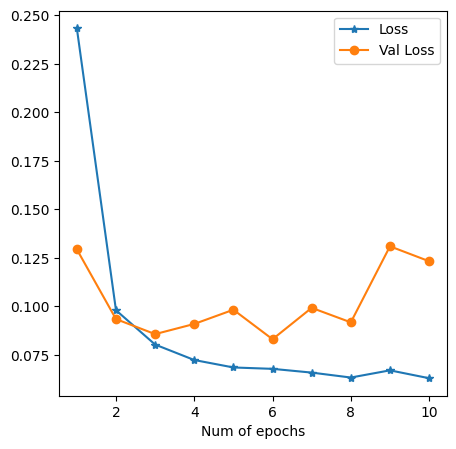

In [9]:
fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(1,11), loss, "*-",label="Loss")
plt.plot(np.arange(1,11), val_loss,"o-",label="Val Loss")
plt.xlabel("Num of epochs")
plt.legend()
plt.show()

Создадим функции атак FGSM, I-FGSM, MI-FGSM

In [10]:
def fgsm_attack(input,epsilon,data_grad):
  pert_out = input + epsilon*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  return pert_out

In [11]:
def ifgsm_attack(input,epsilon,data_grad):
 iter = 10
 alpha = epsilon/iter
 pert_out = input
 for i in range(iter-1):
  pert_out = pert_out + alpha*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  if torch.norm((pert_out-input),p=float('inf')) > epsilon:
    break
 return pert_out

In [12]:
def mifgsm_attack(input,epsilon,data_grad):
  iter=10
  decay_factor=1.0
  pert_out = input
  alpha = epsilon/iter
  g=0
  for i in range(iter-1):
    g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)
    pert_out = pert_out + alpha*torch.sign(g)
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

Создадим функцию проверки

In [13]:
def test(model,device,test_loader,epsilon,attack):
  correct = 0
  adv_examples = []
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    data.requires_grad = True
    output = model(data)
    init_pred = output.max(1, keepdim=True)[1]
    if init_pred.item() != target.item():
      continue
    loss = F.nll_loss(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data
    if attack == "fgsm":
      perturbed_data = fgsm_attack(data,epsilon,data_grad)
    elif attack == "ifgsm":
      perturbed_data = ifgsm_attack(data,epsilon,data_grad)
    elif attack == "mifgsm":
      perturbed_data = mifgsm_attack(data,epsilon,data_grad)
    output = model(perturbed_data)
    final_pred = output.max(1, keepdim=True)[1]
    if final_pred.item() == target.item():
      correct += 1
    if (epsilon == 0) and (len(adv_examples) < 5):
      adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
      adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex))
    else:
      if len(adv_examples) < 5:
        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex))
  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct,  len(test_loader), final_acc))
  return final_acc, adv_examples

Построим графики успешности атак(Accuracy/эпсилон)
и примеры выполненных атак в зависимости от степени
возмущения epsilon

Epsilon: 0	Test Accuracy = 9613 / 10000 = 0.9613
Epsilon: 0.007	Test Accuracy = 9564 / 10000 = 0.9564
Epsilon: 0.01	Test Accuracy = 9550 / 10000 = 0.955
Epsilon: 0.02	Test Accuracy = 9485 / 10000 = 0.9485
Epsilon: 0.03	Test Accuracy = 9406 / 10000 = 0.9406
Epsilon: 0.05	Test Accuracy = 9197 / 10000 = 0.9197
Epsilon: 0.1	Test Accuracy = 7986 / 10000 = 0.7986
Epsilon: 0.2	Test Accuracy = 3821 / 10000 = 0.3821
Epsilon: 0.3	Test Accuracy = 2255 / 10000 = 0.2255


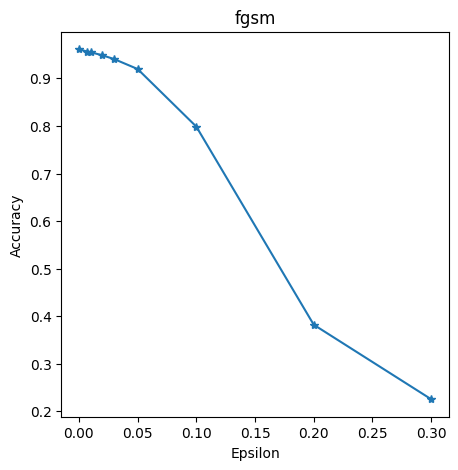

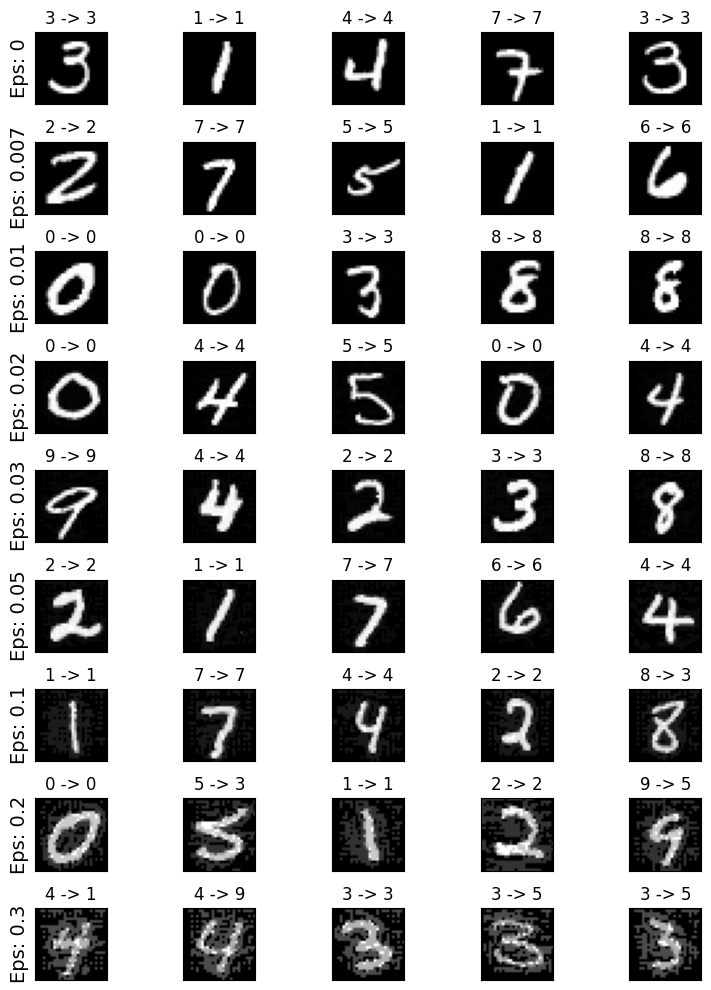

Epsilon: 0	Test Accuracy = 9626 / 10000 = 0.9626
Epsilon: 0.007	Test Accuracy = 9574 / 10000 = 0.9574
Epsilon: 0.01	Test Accuracy = 9579 / 10000 = 0.9579
Epsilon: 0.02	Test Accuracy = 9510 / 10000 = 0.951
Epsilon: 0.03	Test Accuracy = 9445 / 10000 = 0.9445
Epsilon: 0.05	Test Accuracy = 9248 / 10000 = 0.9248
Epsilon: 0.1	Test Accuracy = 8292 / 10000 = 0.8292
Epsilon: 0.2	Test Accuracy = 4552 / 10000 = 0.4552
Epsilon: 0.3	Test Accuracy = 2516 / 10000 = 0.2516


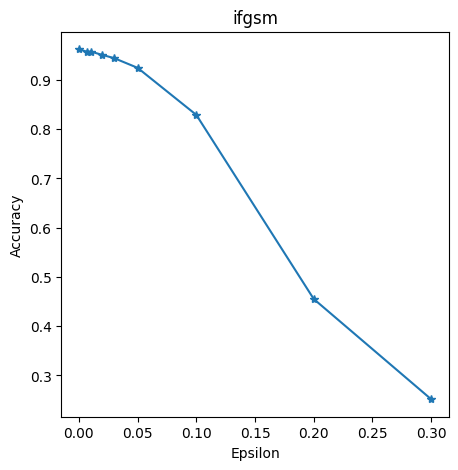

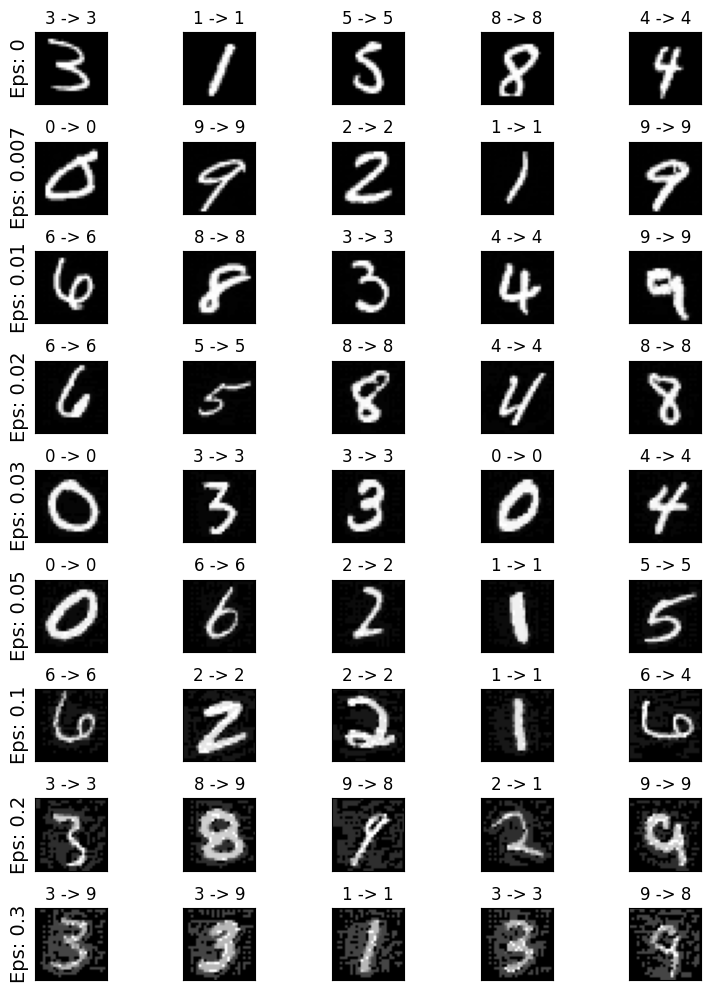

Epsilon: 0	Test Accuracy = 9595 / 10000 = 0.9595
Epsilon: 0.007	Test Accuracy = 9576 / 10000 = 0.9576
Epsilon: 0.01	Test Accuracy = 9569 / 10000 = 0.9569
Epsilon: 0.02	Test Accuracy = 9506 / 10000 = 0.9506
Epsilon: 0.03	Test Accuracy = 9438 / 10000 = 0.9438
Epsilon: 0.05	Test Accuracy = 9217 / 10000 = 0.9217
Epsilon: 0.1	Test Accuracy = 8329 / 10000 = 0.8329
Epsilon: 0.2	Test Accuracy = 4603 / 10000 = 0.4603
Epsilon: 0.3	Test Accuracy = 2452 / 10000 = 0.2452


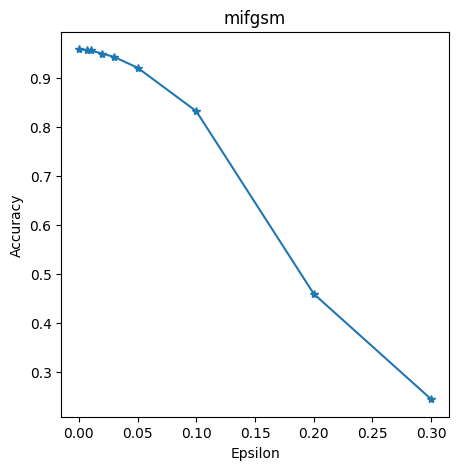

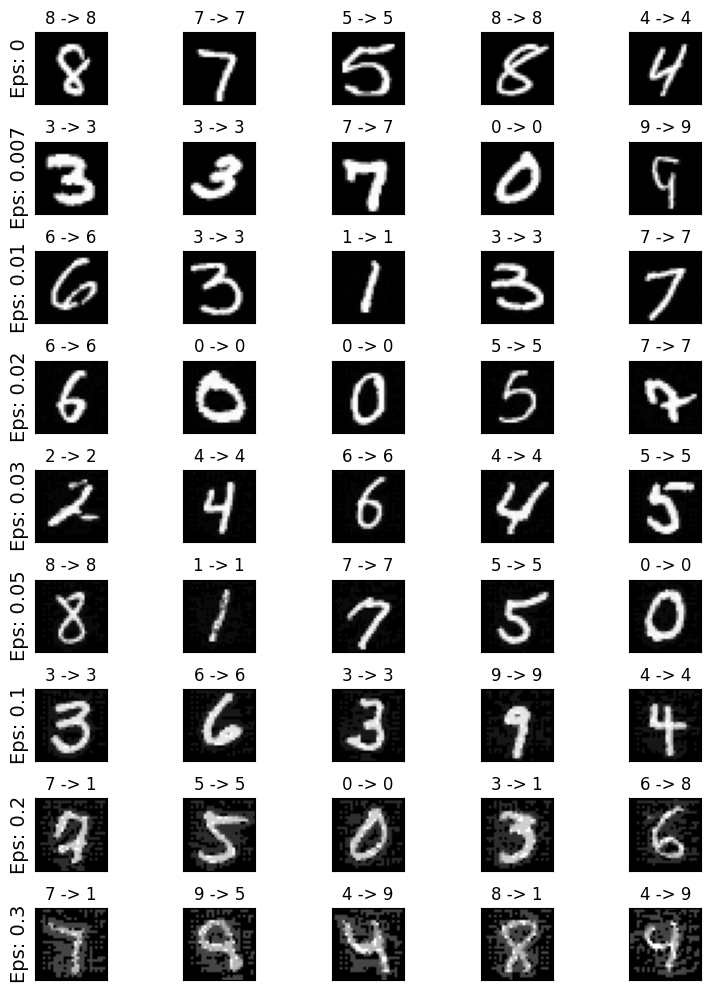

In [14]:
epsilons = [0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
for attack in ("fgsm","ifgsm","mifgsm"):
  accuracies = []
  examples = []
  for eps in epsilons:
    acc, ex = test(model, device,test_loader,eps,attack)
    accuracies.append(acc)
    examples.append(ex)
  plt.figure(figsize=(5,5))
  plt.plot(epsilons, accuracies, "*-")
  plt.title(attack)
  plt.xlabel("Epsilon")
  plt.ylabel("Accuracy")
  plt.show()
  cnt = 0
  plt.figure(figsize=(8,10))
  for i in range(len(epsilons)):
    for j in range(len(examples[i])):
      cnt += 1
      plt.subplot(len(epsilons),len(examples[0]),cnt)
      plt.xticks([], [])
      plt.yticks([], [])
      if j == 0:
        plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
      orig,adv,ex = examples[i][j]
      plt.title("{} -> {}".format(orig, adv))
      plt.imshow(ex, cmap="gray")
  plt.tight_layout()
  plt.show()

Создадим 2 класса НС

In [15]:
class NetF(nn.Module):
  def __init__(self):
    super(NetF, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)
  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x

In [16]:
class NetF1(nn.Module):
  def __init__(self):
    super(NetF1, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, 3, 1)
    self.conv2 = nn.Conv2d(16, 32, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(4608, 64)
    self.fc2 = nn.Linear(64, 10)
  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x

Переопределим функцию обучения и тестирования

In [17]:
def fit(model,device,optimizer,scheduler,criterion,train_loader,val_loader,Temp,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label = data[0].to(device),data[1].to(device)
        output = model(input)
        output = F.log_softmax(output/Temp,dim=1)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
      else:
        val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss
def test(model,device,test_loader,epsilon,Temp,attack):
  correct=0
  adv_examples = []
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    data.requires_grad = True
    output = model(data)
    output = F.log_softmax(output/Temp,dim=1)
    init_pred = output.max(1, keepdim=True)[1]
    if init_pred.item() != target.item():
      continue
    loss = F.nll_loss(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data
    if attack == "fgsm":
      perturbed_data = fgsm_attack(data,epsilon,data_grad)
    elif attack == "ifgsm":
      perturbed_data = ifgsm_attack(data,epsilon,data_grad)
    elif attack == "mifgsm":
      perturbed_data = mifgsm_attack(data,epsilon,data_grad)
    output = model(perturbed_data)
    final_pred = output.max(1, keepdim=True)[1]
    if final_pred.item() == target.item():
      correct += 1
    if (epsilon == 0) and (len(adv_examples) < 5):
      adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
      adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
    else:
      if len(adv_examples) < 5:
        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
  return final_acc,adv_examples

Создадим функцию защиты методом дистилляции

In [18]:
def defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons):
  modelF = NetF().to(device)
  optimizerF = optim.Adam(modelF.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF = optim.lr_scheduler.ReduceLROnPlateau(optimizerF, mode='min', factor=0.1, patience=3)
  modelF1 = NetF1().to(device)
  optimizerF1 = optim.Adam(modelF1.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF1 = optim.lr_scheduler.ReduceLROnPlateau(optimizerF1, mode='min', factor=0.1, patience=3)
  criterion = nn.NLLLoss()
  lossF,val_lossF=fit(modelF,device,optimizerF,schedulerF,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF,"o-",label="Val Loss")
  plt.title("Network F")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()
  #converting target labels to soft labels
  for data in train_loader:
    input, label = data[0].to(device),data[1].to(device)
    softlabel = F.log_softmax(modelF(input),dim=1)
    data[1] = softlabel
  lossF1,val_lossF1=fit(modelF1,device,optimizerF1,schedulerF1,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF1, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF1,"o-",label="Val Loss")
  plt.title("Network F'")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()
  model = NetF1().to(device)
  model.load_state_dict(modelF1.state_dict())
  for attack in ("fgsm","ifgsm","mifgsm"):
    accuracies = []
    examples = []
    for eps in epsilons:
      acc, ex = test(model,device,test_loader,eps,1,"fgsm")
      accuracies.append(acc)
      examples.append(ex)
    plt.figure(figsize=(5,5))
    plt.plot(epsilons, accuracies, "*-")
    plt.title(attack)
    plt.xlabel("Epsilon")
    plt.ylabel("Accuracy")
    plt.show()
    cnt = 0
    plt.figure(figsize=(8,10))
    for i in range(len(epsilons)):
      for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
          plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
  plt.tight_layout()
  plt.show()


Получим результаты оценки защищенных сетей

Fitting the model...


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 1 Loss: 0.5562089400215493 Val_Loss: 0.00011149379387497902
Epoch: 2 Loss: 0.33475335555931 Val_Loss: 0.00020087575912475586
Epoch: 3 Loss: 0.25862170539046975 Val_Loss: 0.0005296089589595795
Epoch: 4 Loss: 0.190677157099624 Val_Loss: 0.0001693984378071036
Epoch: 5 Loss: 0.15163088443849942 Val_Loss: 2.4187059607356785e-07
Epoch: 6 Loss: 0.1265160101849321 Val_Loss: 1.1801024810864647e-08
Epoch: 7 Loss: 0.11237314078307879 Val_Loss: 2.801398568408331e-09
Epoch: 8 Loss: 0.10201299918591994 Val_Loss: 6.668312940746546e-07
Epoch: 9 Loss: 0.09792410799153581 Val_Loss: 1.558509894821327e-05
Epoch: 10 Loss: 0.0941891972631892 Val_Loss: 1.9588666036725045e-07


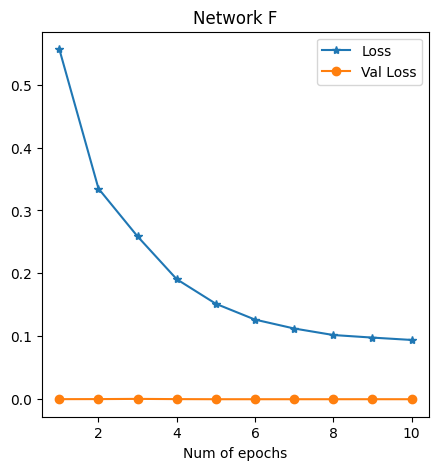

Fitting the model...
Epoch: 1 Loss: 0.7119057472861273 Val_Loss: 0.00015477910935878753
Epoch: 2 Loss: 0.47526786822583317 Val_Loss: 1.474692989140749e-05
Epoch: 3 Loss: 0.42827975793901213 Val_Loss: 2.931312449800316e-06
Epoch: 4 Loss: 0.3929323631814547 Val_Loss: 8.954685032367706e-05
Epoch: 5 Loss: 0.3537366056917966 Val_Loss: 3.729340583086014e-05
Epoch: 6 Loss: 0.3075665797859794 Val_Loss: 0.0013252342419698834
Epoch: 7 Loss: 0.2648324794200162 Val_Loss: 2.7755777118727567e-07
Epoch: 8 Loss: 0.2337261026564832 Val_Loss: 1.949940137565136e-05
Epoch: 9 Loss: 0.21211580473073624 Val_Loss: 1.9940164024592376e-05
Epoch: 10 Loss: 0.19684954207914504 Val_Loss: 1.1350713593856199e-07


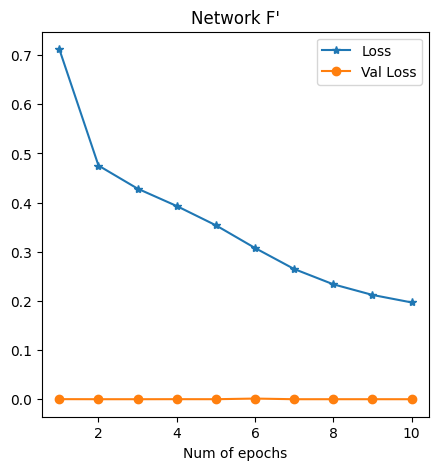

Epsilon: 0	Test Accuracy = 9181 / 10000 = 0.9181
Epsilon: 0.007	Test Accuracy = 9145 / 10000 = 0.9145
Epsilon: 0.01	Test Accuracy = 9169 / 10000 = 0.9169
Epsilon: 0.02	Test Accuracy = 9159 / 10000 = 0.9159
Epsilon: 0.03	Test Accuracy = 9146 / 10000 = 0.9146
Epsilon: 0.05	Test Accuracy = 9131 / 10000 = 0.9131
Epsilon: 0.1	Test Accuracy = 9092 / 10000 = 0.9092
Epsilon: 0.2	Test Accuracy = 9034 / 10000 = 0.9034
Epsilon: 0.3	Test Accuracy = 9001 / 10000 = 0.9001


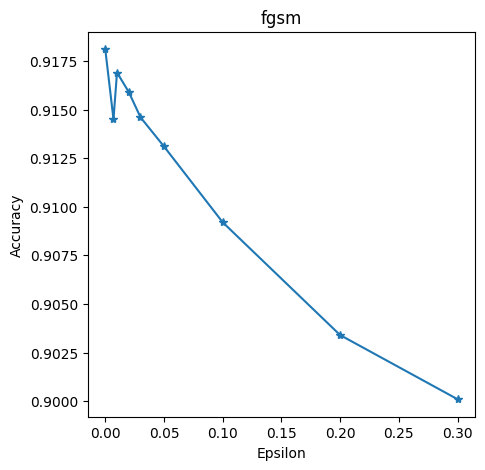

Epsilon: 0	Test Accuracy = 9176 / 10000 = 0.9176
Epsilon: 0.007	Test Accuracy = 9162 / 10000 = 0.9162
Epsilon: 0.01	Test Accuracy = 9144 / 10000 = 0.9144
Epsilon: 0.02	Test Accuracy = 9144 / 10000 = 0.9144
Epsilon: 0.03	Test Accuracy = 9141 / 10000 = 0.9141
Epsilon: 0.05	Test Accuracy = 9100 / 10000 = 0.91
Epsilon: 0.1	Test Accuracy = 9069 / 10000 = 0.9069
Epsilon: 0.2	Test Accuracy = 8983 / 10000 = 0.8983
Epsilon: 0.3	Test Accuracy = 8970 / 10000 = 0.897


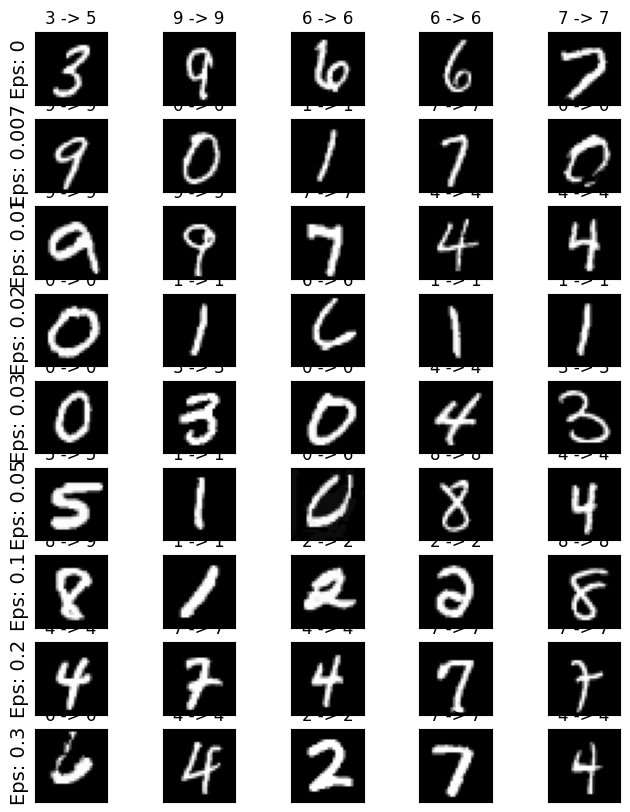

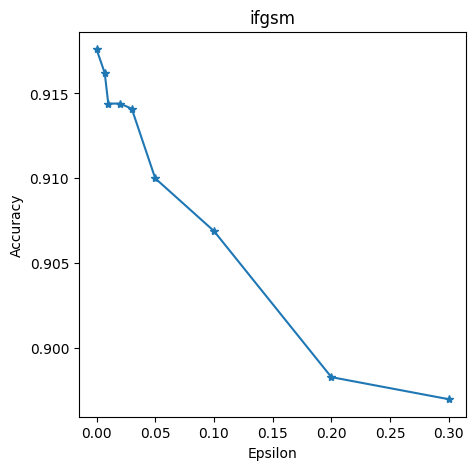

Epsilon: 0	Test Accuracy = 9162 / 10000 = 0.9162
Epsilon: 0.007	Test Accuracy = 9172 / 10000 = 0.9172
Epsilon: 0.01	Test Accuracy = 9153 / 10000 = 0.9153
Epsilon: 0.02	Test Accuracy = 9149 / 10000 = 0.9149
Epsilon: 0.03	Test Accuracy = 9143 / 10000 = 0.9143
Epsilon: 0.05	Test Accuracy = 9094 / 10000 = 0.9094
Epsilon: 0.1	Test Accuracy = 9094 / 10000 = 0.9094
Epsilon: 0.2	Test Accuracy = 9021 / 10000 = 0.9021
Epsilon: 0.3	Test Accuracy = 9006 / 10000 = 0.9006


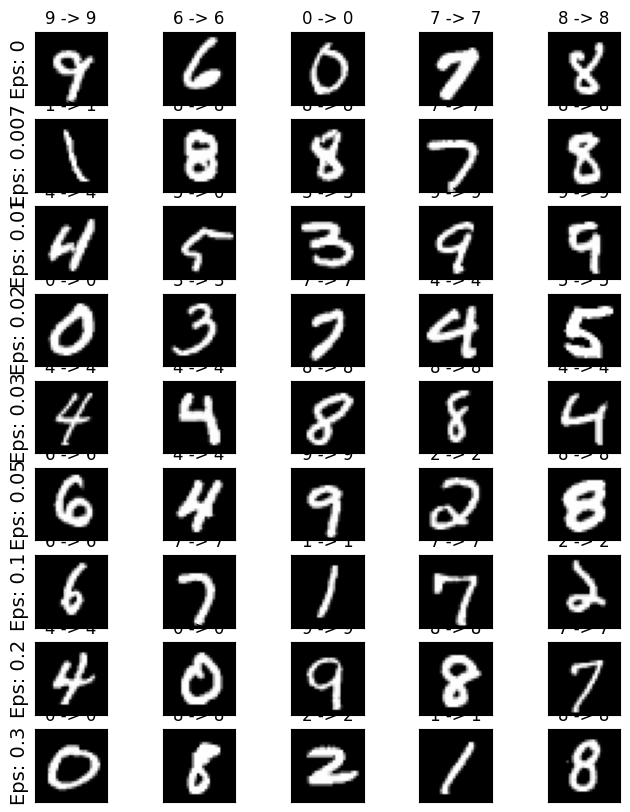

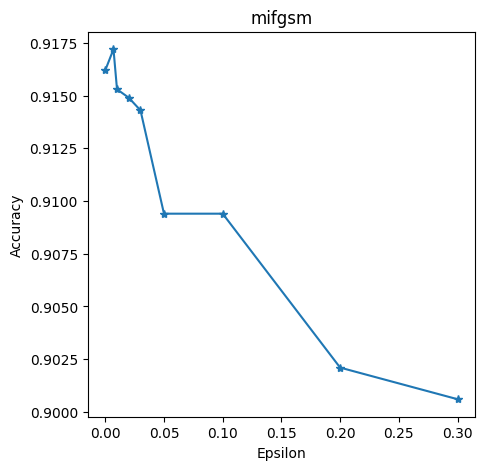

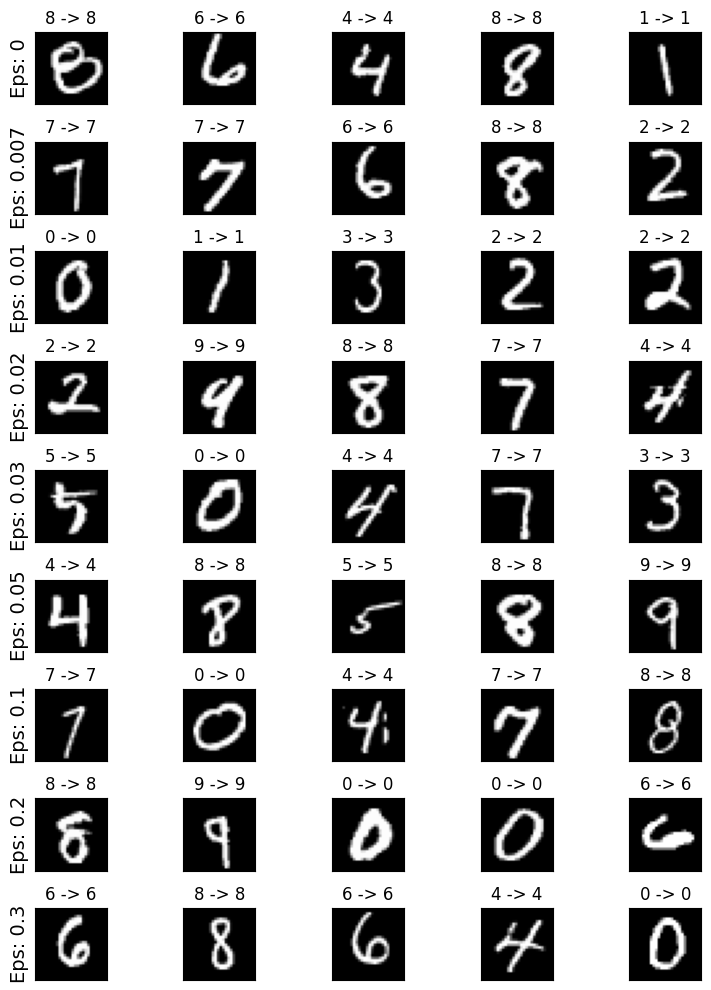

In [19]:
Temp=100
epochs=10
epsilons=[0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons)